In [1]:
options(warn = -1)

suppressPackageStartupMessages({
  library(org.Hs.eg.db)
  library(tidyverse)
  library(rasilabRtemplates)
  library(ggpubr)
})

cbPalette_12 <- c(
  "#DDCC78", "#CC6677", "#6699CC", "#661100", "#117733", "#999933",
  "#332288", "#AA4499", "#44AA99", "#882255", "#88CCEE", "#999999"
)

theme_set(theme_rasilab() +
  theme(
    axis.line = element_line(color = "grey"),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ))

fdr_cutoff <- 0.25
p_value_cutoff <- 0.05
sgrna_cutoff <- 3

set.seed(111)

In [2]:
orgdb <- org.Hs.eg.db

ribi <- AnnotationDbi::select(orgdb, keytype = "GOALL", keys = c("GO:0042273", "GO:0042274"), columns = c("SYMBOL")) %>%
  as_tibble() %>%
  janitor::clean_names() %>%
  distinct(goall, symbol) %>%
  dplyr::rename(gene = symbol, go_id = goall) %>%
  mutate(annotation = if_else(go_id == "GO:0042273", "60S biogenesis", "40S biogenesis")) %>%
  filter(!str_detect(gene, "^RPL|^RPS|GNB2L1|RACK1"))

'select()' returned 1:many mapping between keys and columns



## Load MaGeCK gene-level results

In [3]:
mageck_gene <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "gene_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc.+polysome")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(rep = str_extract(sample_name, "rep1|rep2")) %>% 
  mutate(treatment = str_extract(treatment, "heavy|light|mono")) %>%
  mutate(control = str_extract(control, "mono|total")) %>%
  filter(!is.na(treatment), !is.na(control), !is.na(rep)) %>% 
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  select(-neg_lfc) %>%
  rename(lfc = pos_lfc, gene = id) %>%
  mutate(p_value = if_else(lfc > 0, pos_p_value, neg_p_value)) %>%
  mutate(fdr = if_else(lfc > 0, pos_fdr, neg_fdr)) %>%
  mutate(goodsgrna = if_else(lfc > 0, pos_goodsgrna, neg_goodsgrna)) %>%
  print()

# A tibble: 8,744 × 20
   sample_name treat…¹ control rep   gene    num neg_s…² neg_p…³ neg_fdr neg_r…⁴
   <chr>       <chr>   <chr>   <chr> <chr> <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1 ntc_polyso… heavy   mono    rep1  ASCC3     4   1       1        1.00    2186
 2 ntc_polyso… heavy   mono    rep1  EIF5A     4   0.990   0.990    1.00    2108
 3 ntc_polyso… heavy   mono    rep1  EEF2      4   1       1        1.00    2185
 4 ntc_polyso… heavy   mono    rep1  NCBP1     4   1       1        1.00    2184
 5 ntc_polyso… heavy   mono    rep1  EIF1…     4   1.00    1.00     1.00    2177
 6 ntc_polyso… heavy   mono    rep1  SUPT…     4   0.699   0.711    1.00    1151
 7 ntc_polyso… heavy   mono    rep1  CPSF3     4   0.850   0.849    1.00    1584
 8 ntc_polyso… heavy   mono    rep1  DUS1L     4   1.00    1.00     1.00    2183
 9 ntc_polyso… heavy   mono    rep1  DHX35     3   0.996   0.996    1.00    2144
10 ntc_polyso… heavy   mono    rep1  TFIP…     4   1.00    1.00     1.00    2182
# … w

## Load MaGeCK sgRNA-level results

In [4]:
mageck_sgrna <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "sgrna_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc.+polysome")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(rep = str_extract(sample_name, "rep1|rep2")) %>% 
  mutate(treatment = str_extract(treatment, "heavy|light|mono")) %>%
  mutate(control = str_extract(control, "mono|total")) %>%
  filter(!is.na(treatment), !is.na(control), !is.na(rep)) %>% 
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  print()

# A tibble: 34,175 × 19
   sample_name treat…¹ control rep   sgrna gene  contr…² treat…³ contr…⁴ treat…⁵
   <chr>       <chr>   <chr>   <chr> <chr> <chr>   <dbl>   <dbl>   <dbl>   <dbl>
 1 ntc_polyso… heavy   mono    rep1  DCPS… DCPS    4397.  12358    4397.  12358 
 2 ntc_polyso… heavy   mono    rep1  RPL2… RPL23  11931     635.  11931     635.
 3 ntc_polyso… heavy   mono    rep1  SDAD… SDAD1  16281    3297   16281    3297 
 4 ntc_polyso… heavy   mono    rep1  RPL9… RPL9   10059     735.  10059     735.
 5 ntc_polyso… heavy   mono    rep1  RPL1… RPL15   8888.    724.   8888.    724.
 6 ntc_polyso… heavy   mono    rep1  RPL8… RPL8    8534.    572.   8534.    572.
 7 ntc_polyso… heavy   mono    rep1  DDX5… DDX54  11094    1811.  11094    1811.
 8 ntc_polyso… heavy   mono    rep1  RPL1… RPL15   8332.    513.   8332.    513.
 9 ntc_polyso… heavy   mono    rep1  RPL8… RPL8    7682.    302.   7682.    302.
10 ntc_polyso… heavy   mono    rep1  RPL2… RPL24   7905.    474.   7905.    474.
# … 

## Calculate correlation between replicates

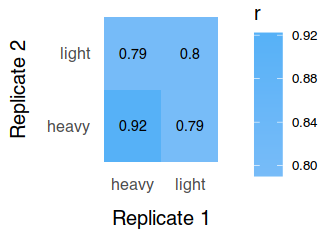

In [5]:
options(repr.plot.width = 2.8, repr.plot.height = 2)

corr_data <- mageck_sgrna %>% 
  filter(control == "mono") %>% 
  # inner_join(gene_hits, by = "gene") %>%
  select(sgrna, treatment, rep, lfc) %>% 
  pivot_wider(names_from = rep, values_from = lfc) %>% 
  rename(sample_name = treatment)

plot_data <- corr_data %>% 
  distinct(sample_name) %>% 
  rename(sample1 = sample_name) %>% 
  mutate(sample2 = sample1) %>% 
  expand(sample1, sample2) %>% 
  mutate(r = map2_dbl(sample1, sample2, function(x,y) {
    xvec <- corr_data %>% filter(sample_name == x) %>% select(sgrna, rep1)
    yvec <- corr_data %>% filter(sample_name == y) %>% select(sgrna, rep2)
    joint <- inner_join(xvec, yvec, by = "sgrna")
    cor.test(joint$rep1, joint$rep2, method = "pearson")$estimate
  }))

plot_data %>% 
  ggplot(aes(x = sample1, y = sample2, fill = r)) +
  geom_tile() +
  geom_text(aes(label = round(r, 2)), size = 3) +
  scale_fill_gradient2(low = "#132B43", high = "#56B1F7") +
  theme(
  axis.line = element_blank(),
  axis.ticks = element_blank(),
  legend.text = element_text(size = 8),
  ) +
  labs(x = "Replicate 1", y = "Replicate 2")

ggsave("../figures/mageck_polysome_correlation.pdf", width = 2.8, height = 2, units = "in")

## Scatter plot of correlation between replicates

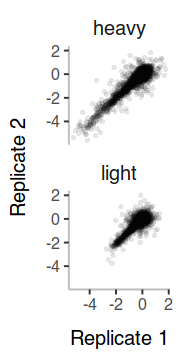

In [6]:
options(repr.plot.width = 1.5, repr.plot.height = 3)

corr_data %>% 
  drop_na() %>% 
  ggplot(aes(x = rep1, y = rep2)) +
  facet_wrap(~ sample_name, ncol = 1) +
  geom_point(color = "black", alpha = 0.1, stroke = NA) +
  labs(x = "Replicate 1", y = "Replicate 2")

ggsave("../figures/mageck_polysome_correlation.pdf", width = 1.5, height = 3)

## Density plot of polysome to monosome ratios

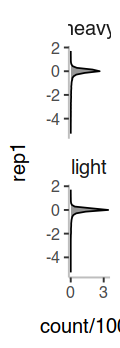

In [7]:
options(repr.plot.width = 1, repr.plot.height = 2.9)

corr_data %>% 
  drop_na() %>% 
  ggplot(aes(x = rep1)) +
  facet_wrap(~ sample_name, ncol = 1) +
  geom_area(aes(y = ..count../1000), stat = "bin", bins = 50, alpha = 0.5, color = "black") +
  scale_y_continuous(breaks = c(0,3)) +
  coord_flip()

ggsave("../figures/mageck_polysome_histogram.pdf", width = 1, height = 2.9)

## Volcano plot of screen results

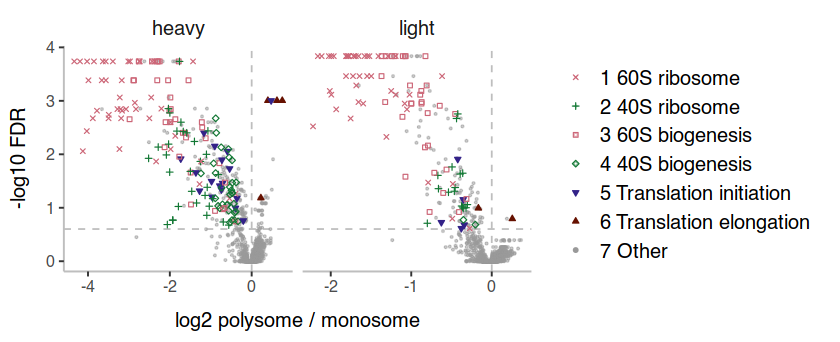

In [8]:
options(repr.plot.width = 7, repr.plot.height = 2.85)


plot_data <- mageck_gene %>%
  filter(control == "mono", rep == "rep1") %>% 
  mutate(annotation = case_when(
    str_detect(gene, "^RPL") ~ "1 60S ribosome",
    str_detect(gene, "^RPS|RACK1") ~ "2 40S ribosome",
    gene %in% (ribi %>% filter(annotation == "60S biogenesis") %>% pull(gene)) ~ "3 60S biogenesis",
    gene %in% (ribi %>% filter(annotation == "40S biogenesis") %>% pull(gene)) ~ "4 40S biogenesis",
    str_detect(gene, "^EIF") & !str_detect(gene, "AK|5A|6$") ~ "5 Translation initiation",
    gene %in% c("EEF2", "EIF5A", "ASCC3", "METAP2") ~ "6 Translation elongation",
    TRUE ~ NA_character_
  )) %>%
  mutate(annotation = if_else(fdr > fdr_cutoff, NA_character_, annotation)) %>%
  mutate(annotation = if_else(is.na(annotation), "7 Other", as.character(annotation)))

plot_data %>%
  ggplot(aes(x = lfc, y = -log10(fdr))) +
  facet_wrap(~treatment, ncol = 3, scales = "free_x") +
  geom_hline(aes(yintercept = -log10(fdr_cutoff)), linetype = 2, linewidth = 0.5, color = "grey") +
  geom_vline(aes(xintercept = 0), linetype = 2, linewidth = 0.5, color = "grey") +
  geom_point(aes(color = annotation, fill = annotation, shape = annotation),
    size = 0.5, alpha = 0.5,
    data = plot_data  %>% filter(annotation == "7 Other"),
    position = position_jitter(height = 0, width = 0, seed = 11)
  ) +
  geom_point(aes(color = annotation, fill = annotation, shape = annotation),
    size = 1, alpha = 1,
    data = plot_data  %>% filter(annotation != "7 Other"),
    position = position_jitter(height = 0, width = 0, seed = 11)
  ) +
  scale_color_manual(values = cbPalette_12[c(2,5,2,5,7,4,12)]) +
  scale_fill_manual(values = cbPalette_12[c(2,5,2,5,7,4,12)]) +
  scale_shape_manual(values = rep(c("cross", "plus", "square open", "diamond open", "triangle down filled", "triangle filled", "circle"), 5)) +
  labs(x = "log2 polysome / monosome", y = "-log10 FDR") +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 3)) +
  theme(legend.title = element_blank())

ggsave("../figures/polysome_volcano.pdf", width = 7, height = 2.85, units = "in")


In [9]:
plot_data  %>% 
  filter(fdr < fdr_cutoff) %>%
  mutate(dir = if_else(lfc > 0, "pos", "neg")) %>%
  group_by(treatment, dir) %>%
  count()

treatment,dir,n
<chr>,<chr>,<int>
heavy,neg,308
heavy,pos,32
light,neg,197
light,pos,2


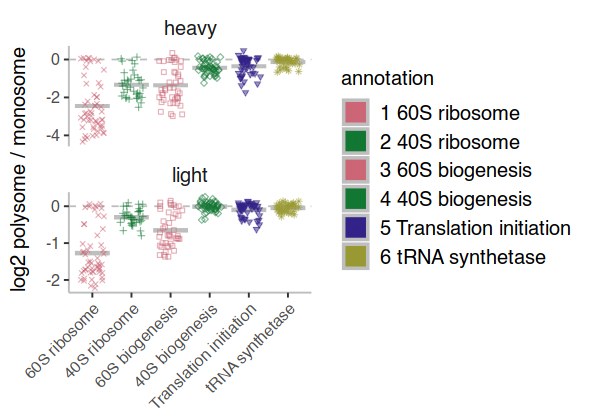

In [10]:
options(repr.plot.width = 5, repr.plot.height = 3.5)

plot_data <- mageck_gene %>%
  filter(control == "mono", rep == "rep1") %>% 
  mutate(annotation = case_when(
    str_detect(gene, "^RPL") ~ "1 60S ribosome",
    str_detect(gene, "^RPS|RACK1") ~ "2 40S ribosome",
    gene %in% (ribi %>% filter(annotation == "60S biogenesis") %>% pull(gene)) ~ "3 60S biogenesis",
    gene %in% (ribi %>% filter(annotation == "40S biogenesis") %>% pull(gene)) ~ "4 40S biogenesis",
    str_detect(gene, "^EIF") & !str_detect(gene, "AK|5A|6$") ~ "5 Translation initiation",
    str_detect(gene, ".ARS.") ~ "6 tRNA synthetase",
    TRUE ~ NA_character_
  )) %>%
  mutate(annotation = if_else(is.na(annotation), "7 Other", as.character(annotation)))


mylabel <- function (x) {
  str_replace(x, ". ", "")
}

plot_data %>%
  filter(!str_detect(annotation, "Other")) %>%
  ggplot(aes(x = annotation, y = lfc, shape = annotation, fill = annotation, color = annotation)) +
  facet_wrap(~treatment, ncol = 1, scales = "free_y") +
  geom_hline(aes(yintercept = 0), linetype = 2, linewidth = 0.5, color = "grey") +
  stat_summary(fun = mean, width = 0.8, color = "grey", geom = "tile", linewidth = 1) +
  geom_point(position = position_jitter(height = 0, width = 0.3, seed = 11), size = 1, alpha = 0.5) +
  scale_color_manual(values = cbPalette_12[c(2,5,2,5,7,6,12)]) +
  scale_x_discrete(labels = mylabel) +
  scale_fill_manual(values = cbPalette_12[c(2,5,2,5,7,6,12)]) +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 3)) +
  scale_shape_manual(values = rep(c("cross", "plus", "square open", "diamond open", "triangle down filled", "asterisk", "circle"), 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_blank()) +
  labs(y = "log2 polysome / monosome") 

ggsave("../figures/polysome_translation_groups.pdf", width = 5, height = 3.5, units = "in")

## Load MaGeCK fitness results for mRNA

In [11]:
mageck_fitness <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "gene_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc.+day(7|13).+total.+total")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  select(-neg_lfc) %>%
  rename(lfc = pos_lfc, gene = id) %>%
  mutate(p_value = if_else(lfc > 0, pos_p_value, neg_p_value)) %>%
  mutate(fdr = if_else(lfc > 0, pos_fdr, neg_fdr)) %>%
  mutate(goodsgrna = if_else(lfc > 0, pos_goodsgrna, neg_goodsgrna)) %>%
  mutate(day = str_extract(treatment, "day\\d+")) %>%
  print()

# A tibble: 4,372 × 20
   sample_…¹ treat…² control gene    num neg_s…³ neg_p…⁴ neg_fdr neg_r…⁵ neg_g…⁶
   <chr>     <chr>   <chr>   <chr> <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1 ntc_day1… ntc_da… ntc_da… ZCCH…     4   1.00    1.00     1.00    2186       0
 2 ntc_day1… ntc_da… ntc_da… PAIP2     4   0.999   0.999    1.00    2162       0
 3 ntc_day1… ntc_da… ntc_da… C17O…     4   1.00    1.00     1.00    2185       0
 4 ntc_day1… ntc_da… ntc_da… RBFO…     4   1.00    1.00     1.00    2184       0
 5 ntc_day1… ntc_da… ntc_da… APOB…     4   0.999   0.999    1.00    2156       0
 6 ntc_day1… ntc_da… ntc_da… LRRF…     4   1.00    1.00     1.00    2183       0
 7 ntc_day1… ntc_da… ntc_da… CNDP2     4   0.998   0.998    1.00    2151       0
 8 ntc_day1… ntc_da… ntc_da… RBMY…     4   1.00    1.00     1.00    2182       0
 9 ntc_day1… ntc_da… ntc_da… DEK       4   1.00    1.00     1.00    2179       0
10 ntc_day1… ntc_da… ntc_da… PABP…     4   1.00    1.00     1.00    2181       0
# … w

## Load MaGeCK genomic DNA fitness results

In [12]:
mageck_grna_fitness <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "gene_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc.+day(5|13).+grna.+grna")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  select(-neg_lfc) %>%
  rename(lfc = pos_lfc, gene = id) %>%
  mutate(p_value = if_else(lfc > 0, pos_p_value, neg_p_value)) %>%
  mutate(fdr = if_else(lfc > 0, pos_fdr, neg_fdr)) %>%
  mutate(goodsgrna = if_else(lfc > 0, pos_goodsgrna, neg_goodsgrna)) %>%
  mutate(day = str_extract(treatment, "day\\d+")) %>%
  print()

# A tibble: 4,372 × 20
   sample_…¹ treat…² control gene    num neg_s…³ neg_p…⁴ neg_fdr neg_r…⁵ neg_g…⁶
   <chr>     <chr>   <chr>   <chr> <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1 ntc_day1… ntc_da… ntc_da… XPO6      4   0.917   0.920    1.00    1723       1
 2 ntc_day1… ntc_da… ntc_da… ZNF3…     4   0.996   0.996    1.00    2140       0
 3 ntc_day1… ntc_da… ntc_da… SYMPK     4   0.628   0.766    1.00    1272       2
 4 ntc_day1… ntc_da… ntc_da… RBM38     4   0.999   0.999    1.00    2182       0
 5 ntc_day1… ntc_da… ntc_da… ENDOV     4   0.702   0.817    1.00    1366       1
 6 ntc_day1… ntc_da… ntc_da… CNP       3   0.997   0.997    1.00    2152       0
 7 ntc_day1… ntc_da… ntc_da… NUCK…     4   0.660   0.791    1.00    1326       1
 8 ntc_day1… ntc_da… ntc_da… RBM43     4   0.995   0.995    1.00    2131       0
 9 ntc_day1… ntc_da… ntc_da… TRMT…     3   0.407   0.563    1.00    1024       1
10 ntc_day1… ntc_da… ntc_da… MSN       4   0.789   0.848    1.00    1463       1
# … w

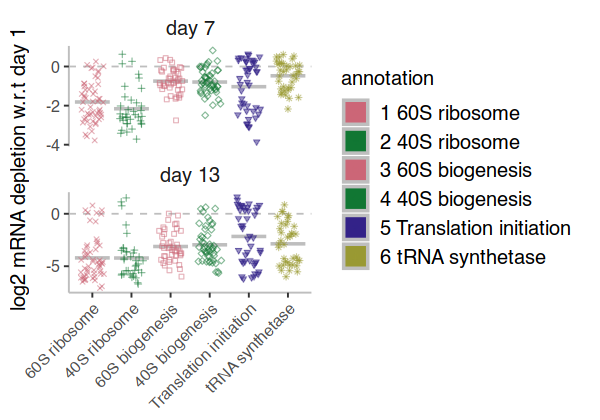

In [13]:
options(repr.plot.width = 5, repr.plot.height = 3.5)

plot_data <- mageck_fitness %>%
  mutate(day = str_replace(day, "day", "day ")) %>%
  mutate(annotation = case_when(
    str_detect(gene, "^RPL") ~ "1 60S ribosome",
    str_detect(gene, "^RPS|RACK1") ~ "2 40S ribosome",
    gene %in% (ribi %>% filter(annotation == "60S biogenesis") %>% pull(gene)) ~ "3 60S biogenesis",
    gene %in% (ribi %>% filter(annotation == "40S biogenesis") %>% pull(gene)) ~ "4 40S biogenesis",
    str_detect(gene, "^EIF") & !str_detect(gene, "AK|5A|6$") ~ "5 Translation initiation",
    str_detect(gene, ".ARS.") ~ "6 tRNA synthetase",
    TRUE ~ NA_character_
  )) %>%
  mutate(annotation = if_else(is.na(annotation), "7 Other", as.character(annotation)))


mylabel <- function (x) {
  str_replace(x, ". ", "")
}

plot_data %>%
  filter(!str_detect(annotation, "Other")) %>%
  ggplot(aes(x = annotation, y = lfc, shape = annotation, fill = annotation, color = annotation)) +
  facet_wrap(~ fct_rev(day), ncol = 1, scales = "free_y") +
  geom_hline(aes(yintercept = 0), linetype = 2, linewidth = 0.5, color = "grey") +
  stat_summary(fun = mean, width = 0.8, color = "grey", geom = "tile", linewidth = 1) +
  geom_point(position = position_jitter(height = 0, width = 0.3, seed = 11), size = 1, alpha = 0.5) +
  scale_color_manual(values = cbPalette_12[c(2,5,2,5,7,6,12)]) +
  scale_x_discrete(labels = mylabel) +
  scale_fill_manual(values = cbPalette_12[c(2,5,2,5,7,6,12)]) +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 3)) +
  scale_shape_manual(values = rep(c("cross", "plus", "square open", "diamond open", "triangle down filled", "asterisk", "circle"), 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_blank()) +
  labs(y = "log2 mRNA depletion w.r.t day 1") 

ggsave("../figures/polysome_comparison_to_mrna_fitness_groups.pdf", width = 5, height = 3.5, units = "in")

## Plot mRNA fitness vs polysome monosome ratio

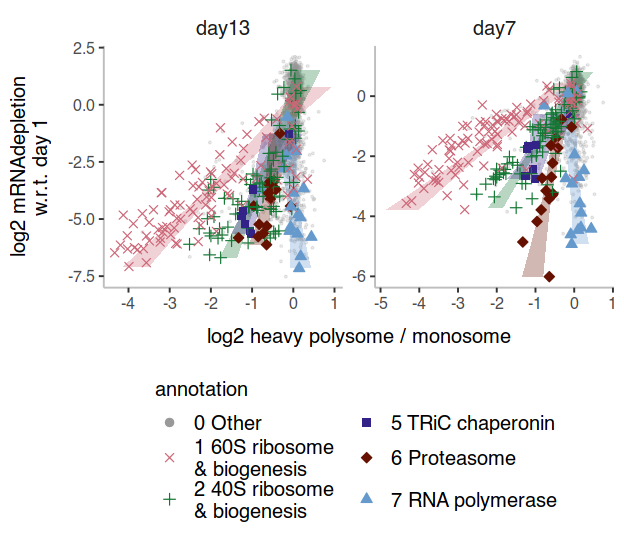

In [14]:
options(repr.plot.width = 5.2, repr.plot.height = 4.5)

plot_data <- mageck_gene %>% 
  filter(control == "mono", treatment == "heavy", rep == "rep1") %>% 
  select(treatment, control, rep, gene, lfc, fdr, p_value) %>% 
  left_join(mageck_fitness  %>% select(day, gene, lfc, fdr), by = "gene", suffix = c ("", ".fitness")) %>% 
  mutate(annotation = case_when(
    str_detect(gene, "^RPL") ~ "1 60S ribosome \n& biogenesis",
    str_detect(gene, "^RPS") ~ "2 40S ribosome \n& biogenesis",
    gene %in% (ribi %>% filter(annotation == "60S biogenesis") %>% pull(gene)) ~ "1 60S ribosome \n& biogenesis",
    gene %in% (ribi %>% filter(annotation == "40S biogenesis") %>% pull(gene)) ~ "2 40S ribosome \n& biogenesis",
    str_detect(gene, "^CCT|^TCP1") ~ "5 TRiC chaperonin",
    str_detect(gene, "^PSM") ~ "6 Proteasome",
    str_detect(gene, "^POLR") ~ "7 RNA polymerase",
    TRUE ~ NA_character_
  )) %>%
  mutate(annotation = if_else(is.na(annotation), "0 Other", as.character(annotation)))

fit_data <- plot_data  %>% 
  filter(annotation != "0 Other") %>% 
  group_by(annotation, day) %>% 
  nest() %>% 
  mutate(fit = map(data, ~lm(lfc ~ lfc.fitness, data = .x))) %>%
  mutate(fit = map(fit, .  %>% predict(interval = "confidence") %>% as_tibble())) %>% 
  unnest(data, fit)

plot_data %>% 
  ggplot(aes(x = lfc, y = lfc.fitness, color = annotation, shape = annotation, fill = annotation)) +
  facet_wrap(~day, ncol = 2, scales = "free") + 
  scale_color_manual(values = cbPalette_12[c(12,2,5,7,4,3)]) +
  scale_fill_manual(values = cbPalette_12[c(12,2,5,7,4,3)]) +
  scale_shape_manual(values = c("circle", "cross", "plus", "square", "diamond filled", "triangle filled", "asterisk", "plus")) +
  geom_point(size = 0.5, alpha = 0.2, data = plot_data  %>%  filter(annotation == "0 Other")) +
  geom_ribbon(aes(xmin = lwr, xmax = upr, y = lfc.fitness), data = fit_data, alpha = 0.3, linewidth = 0, show.legend = F) +
  geom_point(size = 2, data = plot_data  %>%  filter(annotation != "0 Other")) +
  labs(x = "log2 heavy polysome / monosome", y = "log2 mRNAdepletion\nw.r.t. day 1") +
  theme(legend.position = "bottom", legend.direction = "vertical") +
  guides(fill = guide_legend(ncol = 2), color = guide_legend(ncol = 2), shape = guide_legend(ncol = 2))

ggsave("../figures/polysome_vs_mrna_fitness.pdf", width = 5.2, height = 4.5)

## Plot polysome ReLiC against gRNA fitness

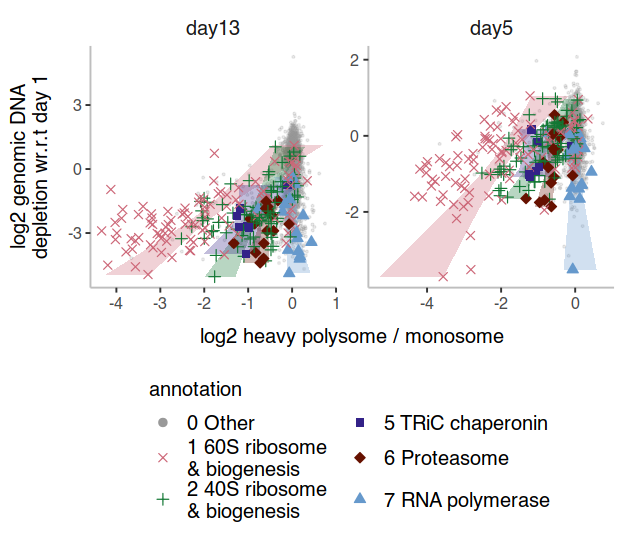

In [15]:
options(repr.plot.width = 5.2, repr.plot.height = 4.5)

plot_data <- mageck_gene %>% 
  filter(control == "mono", treatment == "heavy", rep == "rep1") %>% 
  select(treatment, control, rep, gene, lfc, fdr) %>% 
  left_join(mageck_grna_fitness  %>% select(day, gene, lfc, fdr), by = "gene", suffix = c ("", ".fitness")) %>% 
  mutate(annotation = case_when(
    str_detect(gene, "^RPL") ~ "1 60S ribosome \n& biogenesis",
    str_detect(gene, "^RPS") ~ "2 40S ribosome \n& biogenesis",
    gene %in% (ribi %>% filter(annotation == "60S biogenesis") %>% pull(gene)) ~ "1 60S ribosome \n& biogenesis",
    gene %in% (ribi %>% filter(annotation == "40S biogenesis") %>% pull(gene)) ~ "2 40S ribosome \n& biogenesis",
    str_detect(gene, "^CCT|^TCP1") ~ "5 TRiC chaperonin",
    str_detect(gene, "^PSM") ~ "6 Proteasome",
    str_detect(gene, "^POLR") ~ "7 RNA polymerase",
    TRUE ~ NA_character_
  )) %>%
  mutate(annotation = if_else(is.na(annotation), "0 Other", as.character(annotation)))

fit_data <- plot_data  %>% 
  filter(annotation != "0 Other") %>% 
  group_by(annotation, day) %>% 
  nest() %>% 
  mutate(fit = map(data, ~lm(lfc ~ lfc.fitness, data = .x))) %>%
  mutate(fit = map(fit, .  %>% predict(interval = "confidence") %>% as_tibble())) %>% 
  unnest(data, fit)

plot_data %>% 
  ggplot(aes(x = lfc, y = lfc.fitness, color = annotation, shape = annotation, fill = annotation)) +
  facet_wrap(~day, ncol = 2, scales = "free") + 
  scale_color_manual(values = cbPalette_12[c(12,2,5,7,4,3)]) +
  scale_fill_manual(values = cbPalette_12[c(12,2,5,7,4,3)]) +
  scale_shape_manual(values = c("circle", "cross", "plus", "square", "diamond filled", "triangle filled", "asterisk", "plus")) +
  geom_point(size = 0.5, alpha = 0.2, data = plot_data  %>%  filter(annotation == "0 Other")) +
  geom_ribbon(aes(xmin = lwr, xmax = upr, y = lfc.fitness), data = fit_data, alpha = 0.3, linewidth = 0, show.legend = F) +
  geom_point(size = 2, data = plot_data  %>%  filter(annotation != "0 Other")) +
  labs(x = "log2 heavy polysome / monosome", y = "log2 genomic DNA\ndepletion wr.r.t day 1") +
  theme(legend.position = "bottom", legend.direction = "vertical") +
  guides(fill = guide_legend(ncol = 2), color = guide_legend(ncol = 2), shape = guide_legend(ncol = 2))

ggsave("../figures/polysome_vs_grna_fitness.pdf", width = 5.2, height = 4.5)

## Plot sgRNA effects for elongation hits

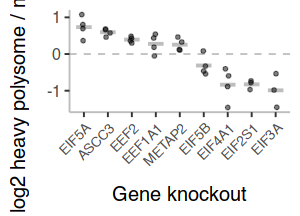

In [16]:
options(repr.plot.width = 2.5, repr.plot.height = 1.8)

plot_data <- mageck_sgrna %>% 
  filter(rep == "rep1", treatment == "heavy", control == "mono") %>%
  filter(gene %in% c("ASCC3", "EIF5A", "METAP2", "EEF2", "EIF4A1", "EIF2S1", "EIF3A", "EIF5B", "EEF1A1")) %>%
  mutate(gene = fct_reorder(gene, -lfc))

plot_data  %>% 
  ggplot(aes(x = gene, y = lfc)) +
  geom_hline(aes(yintercept = 0), linetype = 2, linewidth = 0.5, color = "grey") +
  stat_summary(fun = mean, width = 0.5, color = "grey", geom = "tile", linewidth = 1) +
  geom_point(position = position_jitter(height = 0, width = 0.1, seed = 11), size = 1, alpha = 0.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8.33)) +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 3)) +
  labs(y = "log2 heavy polysome / monosome", x = "Gene knockout")

ggsave("../figures/elongation_vs_initiation_sgrna.pdf", width = 2.5, height = 1.8)

## Read GORILLA GO terms

In [17]:
gorilla <- read_csv("../data/gorilla/ntc_polysome_bc1_heavy_rep1_vs_ntc_polysome_bc1_mono_rep1.csv", show_col_types = F) %>% 
  janitor::clean_names() %>% 
  mutate(enrichment = str_extract(enrichment_n_b_n_b, "\\d+\\.\\d+")) %>%
  select(-genes, -enrichment_n_b_n_b, -p_value) %>% 
  print()

# A tibble: 347 × 6
   go_term    description                       fdr_q_…¹ ontol…² direc…³ enric…⁴
   <chr>      <chr>                                <dbl> <chr>   <chr>   <chr>  
 1 GO:0006364 rRNA processing                   1.92e-52 Process Down    4.08   
 2 GO:0019083 viral transcription               1.28e-51 Process Down    6.09   
 3 GO:0016072 rRNA metabolic process            1.27e-50 Process Down    3.90   
 4 GO:0006614 SRP-dependent cotranslational pr… 3.49e-50 Process Down    6.01   
 5 GO:0006413 translational initiation          1.03e-49 Process Down    6.16   
 6 GO:0006613 cotranslational protein targetin… 9.43e-49 Process Down    5.88   
 7 GO:0070972 protein localization to endoplas… 4.66e-48 Process Down    5.81   
 8 GO:0072599 establishment of protein localiz… 4.08e-48 Process Down    5.81   
 9 GO:0045047 protein targeting to ER           3.63e-48 Process Down    5.81   
10 GO:0006612 protein targeting to membrane     1.78e-47 Process Down    5.75   
# … with

## Show selected GO terms enriched in downregulated genes

In [18]:
subset_go_terms <- c(
  "GO:0006364" = "rRNA processing",
  "GO:0006413" = "translational initiation",
  "GO:0022625" = "cytosolic large ribosomal subunit",
  "GO:0022627" = "cytosolic small ribosomal subunit",
  "GO:0000502" = "proteasome complex",
  "GO:0005832" = "chaperonin-containing T-complex"
)

gorilla  %>% 
  filter(go_term %in% names(subset_go_terms)) %>%
  select(go_term, description, fdr_q_value, enrichment)

go_term,description,fdr_q_value,enrichment
<chr>,<chr>,<dbl>,<chr>
GO:0006364,rRNA processing,1.92e-52,4.08
GO:0006413,translational initiation,1.03e-49,6.16
GO:0022625,cytosolic large ribosomal subunit,3.97e-37,19.60
GO:0022627,cytosolic small ribosomal subunit,3.70e-16,4.72
GO:0000502,proteasome complex,3.44e-05,3.61
GO:0005832,chaperonin-containing T-complex,4.42e-04,9.25


## Show selected GO terms enriched in upregulated genes

In [19]:
subset_go_terms <- c(
  "GO:0008380" = "RNA splicing",
  "GO:0031124" = "mRNA 3'-end processing",
  "GO:0006406" = "mRNA export from nucleus"
)

gorilla  %>% 
  filter(go_term %in% names(subset_go_terms)) %>%
  select(go_term, description, fdr_q_value, enrichment)

go_term,description,fdr_q_value,enrichment
<chr>,<chr>,<dbl>,<chr>
GO:0008380,RNA splicing,6.21e-08,1.74
GO:0031124,mRNA 3'-end processing,2.11e-03,2.28
GO:0006406,mRNA export from nucleus,1.42e-02,3.63
